In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
pip install keras-self-attention

In [90]:
#importing packages
import pandas as pd
import numpy as np
import tensorflow as tf
import pywt
import keras
from keras_self_attention import SeqSelfAttention

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from skimage.restoration import denoise_wavelet
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Lambda, Bidirectional, GRU, Conv1D, TimeDistributed
from tensorflow.keras.layers import RepeatVector, MaxPooling1D, Input, Attention, Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [256]:
#setting figure size
rcParams['figure.figsize'] = 20,10

#for normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/content/drive/My Drive/DATA/SP_INDEX_K.csv')
df_idx = pd.read_csv('/content/drive/My Drive/DATA/USD_IDX_JULY15_JULY20.csv')
df_idx = df_idx.fillna(method='bfill', axis=0)

#df['Date'] = df[['Date', 'Time']].apply(lambda x: '-'.join(x), axis=1)
#print the head

In [ ]:
df

,Date,Open,High,Low,Close,Volume,Relative Strength Index - RSI - RSI(14),"MACD - MACD(12,26,9)",MACD - Histogram,"MACD - Signal Line(MACD(12,26,9),9,Modern)","Exponential Moving Average - EMA - EMA(10,Modern)","Exponential Moving Average - EMA - EMA(60,Modern)","Slow %K - SS %K(14,3)",Slow %D - SS %D(3),"BOLLINGER BAND ? - BB - BBUpper(20,2)","BOLLINGER BAND ? - BB - BBLower(20,2)","Historical Volatility - HV - HV(Close,20,251)",Volatility (HVs & IVs) - VOL - hv360,Volatility (HVs & IVs) - VOL - iv360
0,08/18/2014,196.80,197.45,196.6900,197.36,75424360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,08/19/2014,197.84,198.54,197.4426,198.39,59134709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,08/20/2014,198.12,199.16,198.0800,198.92,72762541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,08/21/2014,199.09,199.76,198.9300,199.50,67790690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,08/22/2014,199.34,199.69,198.7400,199.19,76107359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,07/20/2020,321.43,325.13,320.6200,324.32,56308749,63.569724,4.422827,0.713695,3.709131,318.852493,305.808397,93.700561,92.359315,326.303351,300.811649,18.876760,28.259199,22.874994
1491,07/21/2020,326.45,326.93,323.9400,325.01,57498967,64.179426,4.651974,0.754274,3.897700,319.972040,306.437958,93.599874,93.573162,327.874506,300.679494,18.820234,28.258699,23.027100
1492,07/22/2020,324.62,327.20,324.5000,326.86,57792915,65.830627,4.926070,0.822696,4.103374,321.224396,307.107533,94.487341,93.929258,329.624802,300.410198,18.841832,28.248699,22.707619
1493,07/23/2020,326.47,327.23,321.4800,322.96,75737989,59.594031,4.773569,0.536156,4.237413,321.539961,307.627286,87.178480,91.755231,330.051675,301.870325,16.616357,28.267700,23.288900


In [ ]:
df_idx

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-27,97.199997,97.290001,96.290001,96.500000,96.500000,0.0
1,2015-07-28,96.580002,96.970001,96.470001,96.769997,96.769997,0.0
2,2015-07-29,96.650002,97.250000,96.500000,96.980003,96.980003,0.0
3,2015-07-30,97.139999,97.769997,97.139999,97.559998,97.559998,0.0
4,2015-07-31,97.470001,97.599998,96.309998,97.370003,97.370003,0.0
...,...,...,...,...,...,...,...
1513,2020-07-19,96.010002,96.180000,95.730003,95.830002,95.830002,0.0
1514,2020-07-20,96.010002,96.180000,95.730003,95.830002,95.830002,0.0
1515,2020-07-21,95.750000,95.919998,95.050003,95.120003,95.120003,0.0
1516,2020-07-22,95.129997,95.410004,94.830002,94.970001,94.970001,0.0


In [111]:
#US DOLLAR INDEX
df_idx['Date'] = pd.to_datetime(df_idx.Date)
df_idx.index = df_idx['Date']
df_idx = df_idx.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df_idx = df_idx.rename(columns={'Close': 'USD Index'})

# plt.plot(df_idx['USD Index'], label='Close US DOLLAR INDEX history')
# plt.legend()
df_idx

,Date,USD Index
Date,,
2015-07-27,2015-07-27,96.500000
2015-07-28,2015-07-28,96.769997
2015-07-29,2015-07-29,96.980003
2015-07-30,2015-07-30,97.559998
2015-07-31,2015-07-31,97.370003
...,...,...
2020-07-19,2020-07-19,95.830002
2020-07-20,2020-07-20,95.830002
2020-07-21,2020-07-21,95.120003


In [257]:
#setting index as date
#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
#df['Date'] = pd.to_datetime(df.Date)
#df.index = df['Date']
df = df.drop(['MACD - MACD(12,26,9)','MACD - Histogram','MACD - Signal Line(MACD(12,26,9),9,Modern)','Slow %K - SS %K(14,3)','Slow %D - SS %D(3)','Volatility (HVs & IVs) - VOL - hv360','Volatility (HVs & IVs) - VOL - iv360'],axis=1)
df = df.rename(columns={'Relative Strength Index - RSI - RSI(14)': 'RSI'})
df = df.rename(columns={'Exponential Moving Average - EMA - EMA(10,Modern)': 'EMA - 10'})
df = df.rename(columns={'Exponential Moving Average - EMA - EMA(60,Modern)': 'EMA - 60'})
df = df.rename(columns={'BOLLINGER BAND ? - BB - BBUpper(20,2)': 'BBUpper'})
df = df.rename(columns={'BOLLINGER BAND ? - BB - BBLower(20,2)': 'BBLower'})
df = df.rename(columns={'Historical Volatility - HV - HV(Close,20,251)': 'Historical Volatility'})
df = df.drop(df.index[0:236],axis=0)
#df = df.drop(df.index[1518:1526],axis=0)

#df = df[df['Date'] < '2020-01-01']
df
#plot
#plt.figure(figsize=(16,8))
#plt.plot(df['Close'], label='Close Price history')
#plt.legend()

,Date,Open,High,Low,Close,Volume,RSI,EMA - 10,EMA - 60,BBUpper,BBLower,Historical Volatility
236,07/27/2015,206.94,207.55,206.260,206.79,132361082,40.614373,209.547393,209.615601,213.885580,203.539420,13.593626
237,07/28/2015,207.79,209.50,206.800,209.33,123544845,49.232359,209.507867,209.606237,213.859366,203.956634,12.007859
238,07/29/2015,209.48,211.04,209.310,210.77,105791255,53.364321,209.737346,209.644394,213.959944,204.348056,12.185363
239,07/30/2015,210.16,211.02,209.420,210.82,91304374,53.505822,209.934192,209.682938,214.115294,204.524707,11.920199
240,07/31/2015,211.42,211.45,210.160,210.50,103266857,52.409801,210.037066,209.709727,214.208510,204.750490,11.933530
...,...,...,...,...,...,...,...,...,...,...,...,...
1490,07/20/2020,321.43,325.13,320.620,324.32,56308749,63.569724,318.852493,305.808397,326.303351,300.811649,18.876760
1491,07/21/2020,326.45,326.93,323.940,325.01,57498967,64.179426,319.972040,306.437958,327.874506,300.679494,18.820234
1492,07/22/2020,324.62,327.20,324.500,326.86,57792915,65.830627,321.224396,307.107533,329.624802,300.410198,18.841832
1493,07/23/2020,326.47,327.23,321.480,322.96,75737989,59.594031,321.539961,307.627286,330.051675,301.870325,16.616357


,Date,Open,High,Low,Close,Volume,RSI,EMA - 10,EMA - 60,BBUpper,BBLower,Historical Volatility
Date,,,,,,,,,,,,
2015-07-27,2015-07-27,206.94,207.55,206.260,206.79,132361082,40.614373,209.547393,209.615601,213.885580,203.539420,13.593626
2015-07-28,2015-07-28,207.79,209.50,206.800,209.33,123544845,49.232359,209.507867,209.606237,213.859366,203.956634,12.007859
2015-07-29,2015-07-29,209.48,211.04,209.310,210.77,105791255,53.364321,209.737346,209.644394,213.959944,204.348056,12.185363
2015-07-30,2015-07-30,210.16,211.02,209.420,210.82,91304374,53.505822,209.934192,209.682938,214.115294,204.524707,11.920199
2015-07-31,2015-07-31,211.42,211.45,210.160,210.50,103266857,52.409801,210.037066,209.709727,214.208510,204.750490,11.933530
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,2020-07-20,321.43,325.13,320.620,324.32,56308749,63.569724,318.852493,305.808397,326.303351,300.811649,18.876760
2020-07-21,2020-07-21,326.45,326.93,323.940,325.01,57498967,64.179426,319.972040,306.437958,327.874506,300.679494,18.820234
2020-07-22,2020-07-22,324.62,327.20,324.500,326.86,57792915,65.830627,321.224396,307.107533,329.624802,300.410198,18.841832


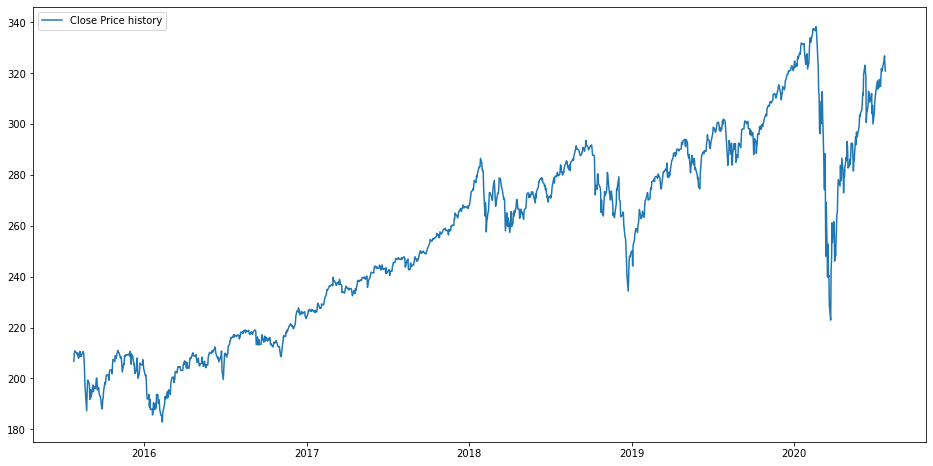

In [258]:
#setting index as date
#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']
#df = df[df['Date'] < '2020-01-01']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.legend()
df

In [132]:
#merging dataframes
df = pd.merge(df, df_idx, how='left', left_index=True, right_index=True)
df = df.fillna(method='ffill', axis=0)
df = df.drop(['Date_y'], axis=1)
df = df.rename(columns={'Date_x':'Date'})
df

,Date,Open_x,High_x,Low_x,Close_x,Volume_x,RSI,EMA - 10,EMA - 60,BBUpper,BBLower,Historical Volatility,Open_y,High_y,Low_y,Close_y,Adj Close,Volume_y
Date,,,,,,,,,,,,,,,,,,
2015-07-27,2015-07-27,206.94,207.55,206.260,206.79,132361082,40.614373,209.547393,209.615601,213.885580,203.539420,13.593626,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28,2015-07-28,207.79,209.50,206.800,209.33,123544845,49.232359,209.507867,209.606237,213.859366,203.956634,12.007859,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-29,2015-07-29,209.48,211.04,209.310,210.77,105791255,53.364321,209.737346,209.644394,213.959944,204.348056,12.185363,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-30,2015-07-30,210.16,211.02,209.420,210.82,91304374,53.505822,209.934192,209.682938,214.115294,204.524707,11.920199,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,2015-07-31,211.42,211.45,210.160,210.50,103266857,52.409801,210.037066,209.709727,214.208510,204.750490,11.933530,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,2020-07-20,321.43,325.13,320.620,324.32,56308749,63.569724,318.852493,305.808397,326.303351,300.811649,18.876760,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21,2020-07-21,326.45,326.93,323.940,325.01,57498967,64.179426,319.972040,306.437958,327.874506,300.679494,18.820234,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-22,2020-07-22,324.62,327.20,324.500,326.86,57792915,65.830627,321.224396,307.107533,329.624802,300.410198,18.841832,NaN,NaN,NaN,NaN,NaN,NaN


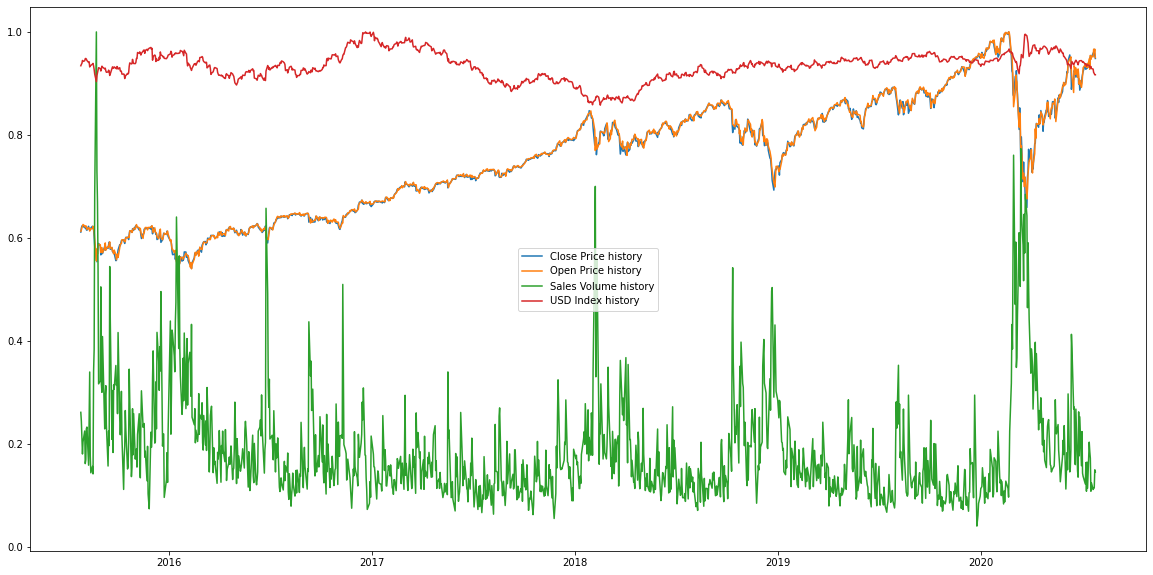

In [ ]:
plt.plot(df['Close']/np.max(df['Close']), label='Close Price history')
plt.plot(df['Open']/np.max(df['Open']), label='Open Price history')
plt.plot(df['Volume']/np.max(df['Volume']), label='Sales Volume history')
plt.plot(df['USD Index']/np.max(df['USD Index']), label='USD Index history')
plt.legend()

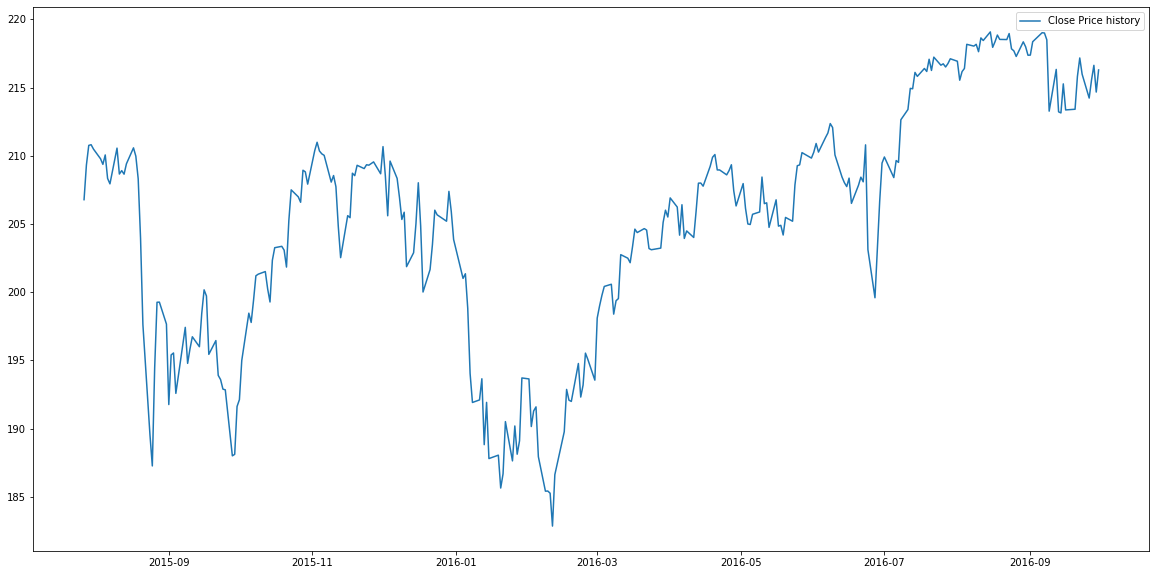

In [ ]:
plt.plot(df['Close'][0:300], label='Close Price history')
plt.legend()

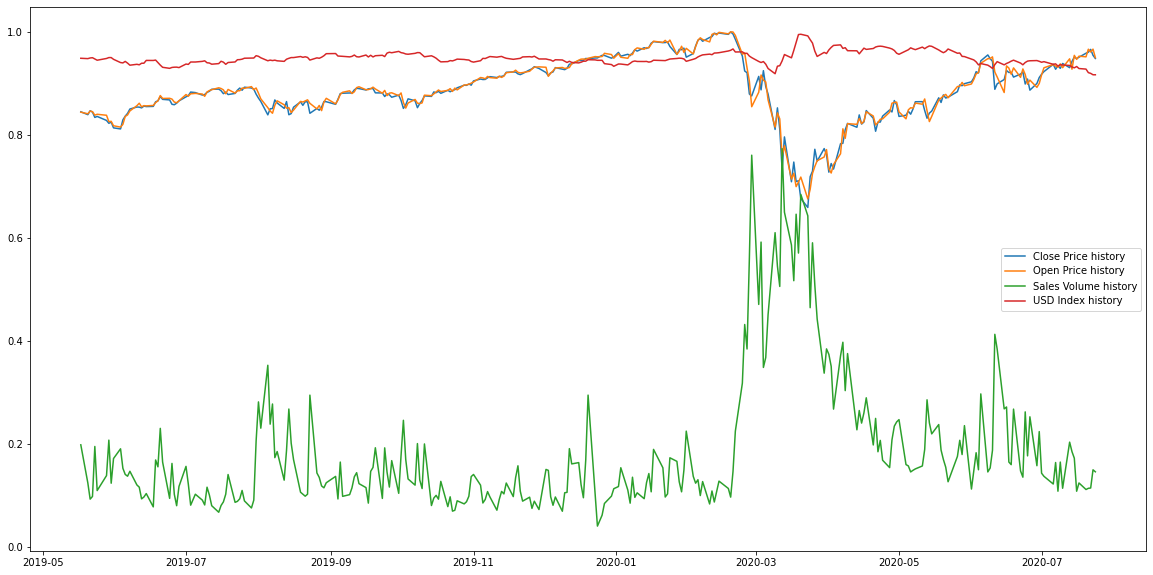

In [ ]:
#plot
plt.plot(df['Close'][-300:]/np.max(df['Close']), label='Close Price history')
plt.plot(df['Open'][-300:]/np.max(df['Open']), label='Open Price history')
plt.plot(df['Volume'][-300:]/np.max(df['Volume']), label='Sales Volume history')
plt.plot(df['USD Index'][-300:]/np.max(df['USD Index']), label='USD Index history')
plt.legend()

In [259]:
#creating dataframe
T = 30 #training period
T_pred = 30 #prediction period

data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close', 'Open', 'Volume', 'RSI', 'EMA - 10','EMA - 60','BBUpper','BBLower','Historical Volatility'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    new_data['Open'][i] = data['Open'][i]
    new_data['Volume'][i] = data['Volume'][i]
    new_data['RSI'][i] = data['RSI'][i]
    new_data['EMA - 10'][i] = data['EMA - 10'][i]
    new_data['EMA - 60'][i] = data['EMA - 60'][i]
    new_data['BBUpper'][i] = data['BBUpper'][i]
    new_data['BBLower'][i] = data['BBLower'][i]
    new_data['Historical Volatility'][i] = data['Historical Volatility'][i]
    #new_data['USD Index'][i] = data['USD Index'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

new_data

,Close,Open,Volume,RSI,EMA - 10,EMA - 60,BBUpper,BBLower,Historical Volatility
Date,,,,,,,,,
2015-07-27,206.79,206.94,132361082,40.6144,209.547,209.616,213.886,203.539,13.5936
2015-07-28,209.33,207.79,123544845,49.2324,209.508,209.606,213.859,203.957,12.0079
2015-07-29,210.77,209.48,105791255,53.3643,209.737,209.644,213.96,204.348,12.1854
2015-07-30,210.82,210.16,91304374,53.5058,209.934,209.683,214.115,204.525,11.9202
2015-07-31,210.5,211.42,103266857,52.4098,210.037,209.71,214.209,204.75,11.9335
...,...,...,...,...,...,...,...,...,...
2020-07-20,324.32,321.43,56308749,63.5697,318.852,305.808,326.303,300.812,18.8768
2020-07-21,325.01,326.45,57498967,64.1794,319.972,306.438,327.875,300.679,18.8202
2020-07-22,326.86,324.62,57792915,65.8306,321.224,307.108,329.625,300.41,18.8418


In [260]:
#creating train and test sets
dataset = new_data.values
dataset_orig = dataset.copy()

#SNR of data before denoising
num = np.sum(dataset[:,0]**2)
den = np.sum((dataset[:,0] - np.mean(dataset[:,0]))**2)
SNR_before = 10*np.log10(num/den)
print('SNR of the signal before denoising: {}'.format(SNR_before))

#DWT on dataset
for i in range(dataset_orig.shape[1]):
  dataset[:,i] = denoise_wavelet(dataset[:,i].astype('float'), wavelet='coif3', mode='soft', method='VisuShrink', rescale_sigma=True)

#SNR of data after denoising
num = np.sum(dataset[:,0]**2)
den = np.sum((dataset[:,0] - np.mean(dataset[:,0]))**2)
SNR = 10*np.log10(num/den)
print('SNR of the signal after denoising: {}'.format(SNR))

split_constant = int(0.2*len(dataset)/T_pred)

train = dataset[:-T_pred*split_constant,:]
valid = dataset_orig[-T_pred*split_constant:,0].reshape(-1,1)

dataset.shape, train.shape, valid.shape, split_constant

SNR of the signal before denoising: 16.654657919448915
SNR of the signal after denoising: 16.668226238078695


((1259, 9), (1019, 9), (240, 1), 8)

In [261]:
#converting dataset into x_train and y_train
k = train.shape[1] # number of features
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(T,len(train)-T_pred):
    x_train.append(scaled_data[i-T:i,:])
    y_train.append(scaled_data[i:i+T_pred,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],k))
#y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],k))
print(x_train.shape, y_train.shape)


(959, 30, 9) (959, 30)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 28, 64)            1792      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 14, 200)           212000    
_________________________________________________________________
dropout_28 (Dropout)         (None, 14, 200)           0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 200)               320800    
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 30, 200)           0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 30, 200)         

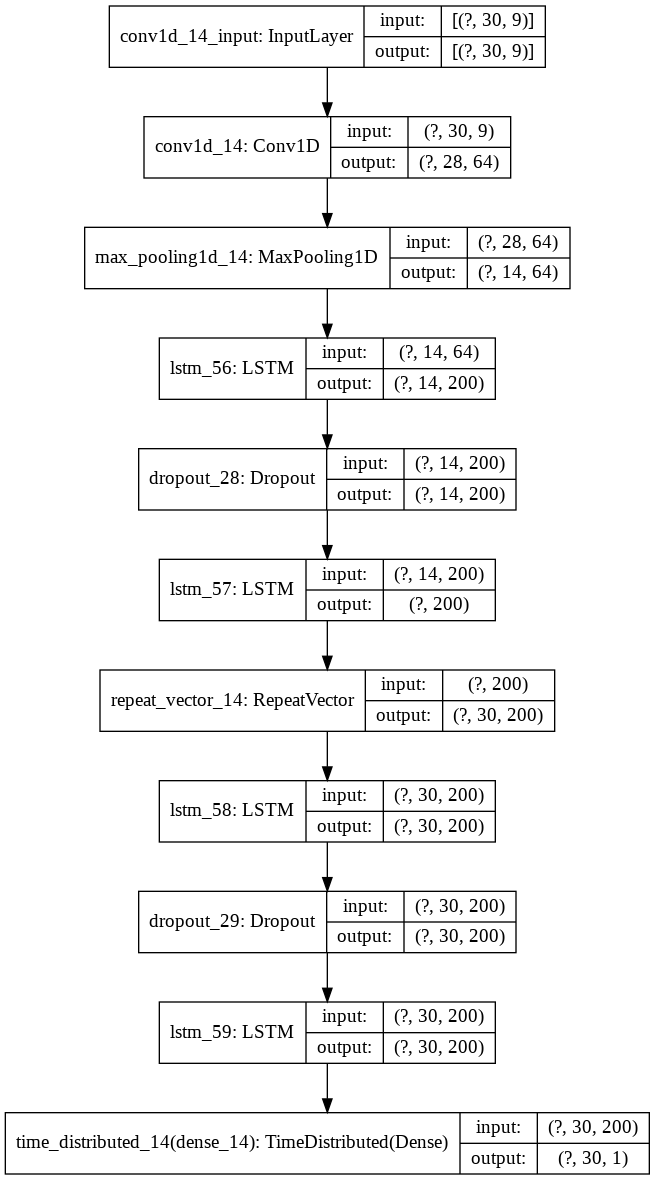

In [262]:
#Encoder_Decoder model
model_name = 'extendedFeatures_Encoder_Decoder_SPY_14'
weight_save_path = '/content/drive/My Drive/LSTM/Results/'

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(T,k)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, activation='tanh'))
model.add(RepeatVector(T_pred))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, activation='tanh', return_sequences=True))
#model.add(TimeDistributed(Dense(100)))
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['mae'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [263]:
#callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/ 20))
checkpoint = ModelCheckpoint(weight_save_path+model_name+'.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, )
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=400, mode='min',restore_best_weights=True)

In [264]:
import time
start = time.time()
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[lr_schedule])
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/100
30/30 [==============================] - 0s 14ms/step - loss: 0.1773 - mae: 0.3729
Epoch 2/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1770 - mae: 0.3726
Epoch 3/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1770 - mae: 0.3726
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1770 - mae: 0.3726
Epoch 5/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1769 - mae: 0.3725
Epoch 6/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1767 - mae: 0.3724
Epoch 7/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1764 - mae: 0.3720
Epoch 8/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1763 - mae: 0.3718
Epoch 9/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1761 - mae: 0.3716
Epoch 10/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1760 - mae: 0.3716
Epoch 11/100
30/30 [=============================

(1e-08, 0.01, 0.0, 1.0)

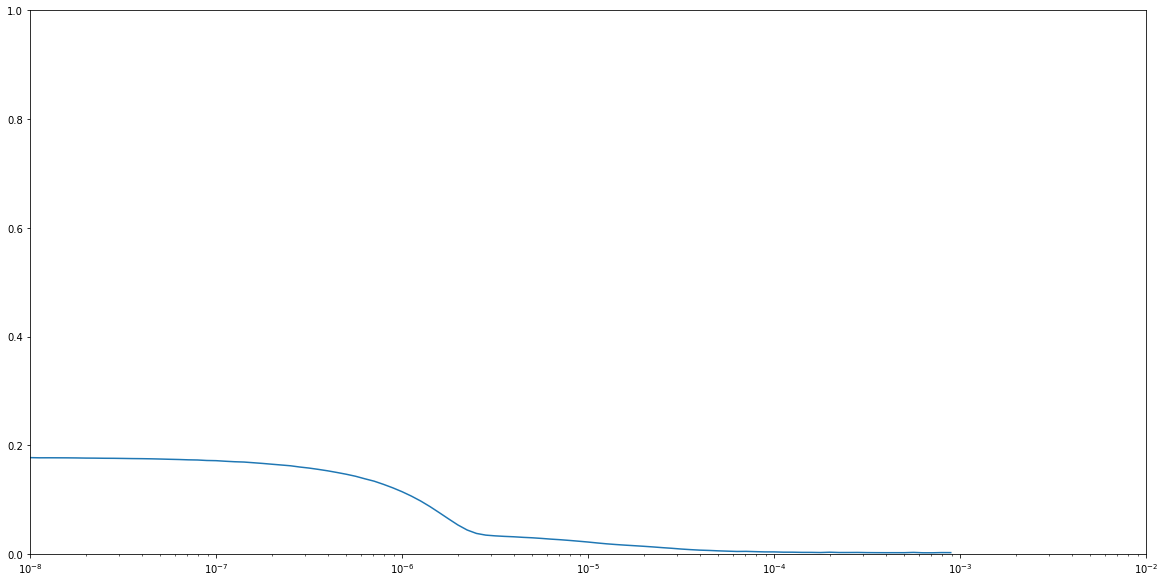

In [265]:
#plotting loss per epoch against learning rate
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-2, 0, 1])
#use this to choose the optimum lr and run the NN for 500 epochs

In [266]:
class stop_training(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('loss')<0.00001):
      print("Stopping training")
      self.model.stop_training = True

stop_training = stop_training()
model.compile(loss='mse', optimizer=Adam(lr=1e-4), metrics=['mae'])
import time
start = time.time()
history = model.fit(x_train, y_train, epochs=1000, batch_size=32, callbacks=[checkpoint, early_stop, stop_training], validation_split=0.1)
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/1000
27/27 [==============================] - 2s 57ms/step - loss: 0.0018 - mae: 0.0327 - val_loss: 0.0049 - val_mae: 0.0591
Epoch 2/1000
27/27 [==============================] - 0s 14ms/step - loss: 0.0015 - mae: 0.0298 - val_loss: 0.0046 - val_mae: 0.0560
Epoch 3/1000
27/27 [==============================] - 0s 12ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 0.0049 - val_mae: 0.0573
Epoch 4/1000
27/27 [==============================] - 0s 13ms/step - loss: 0.0015 - mae: 0.0295 - val_loss: 0.0025 - val_mae: 0.0395
Epoch 5/1000
27/27 [==============================] - 0s 12ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 0.0041 - val_mae: 0.0500
Epoch 6/1000
27/27 [==============================] - 0s 12ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 0.0052 - val_mae: 0.0575
Epoch 7/1000
27/27 [==============================] - 0s 12ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 0.0040 - val_mae: 0.0483
Epoch 8/1000
27/27 [==============================] - 0s 13ms/step - 

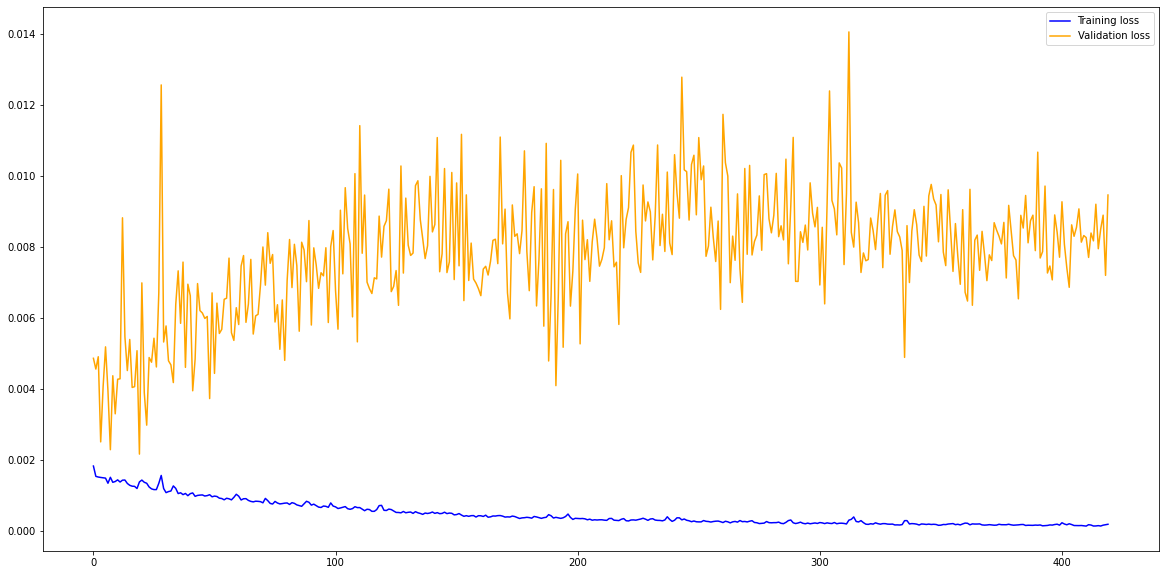

In [267]:
#Plotting the loss
plt.plot(history.history['loss'], color='blue', label='Training loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation loss')
plt.legend()

In [268]:
model.load_weights(weight_save_path+model_name+'.h5')


In [269]:
#Predictions on test set
closing_price = np.zeros((len(valid)))
X_test = dataset[-(len(valid)+T):,:]

for i in range(0,len(valid),T_pred):
  X_test_scaled = scaler.transform(X_test[i:i+T,:])
  X_test_scaled = X_test_scaled.reshape(1,-1,k)
  pred = model.predict(X_test_scaled)
  closing_price[i:i+T_pred] = np.squeeze(pred)

closing_price = closing_price.reshape(-1,1)
closing_price = np.concatenate((closing_price, scaled_data[-(len(valid)):,1:]), axis=1)
closing_price = scaler.inverse_transform(closing_price)
closing_price = closing_price[:,0].reshape(-1,1)

closing_price.shape

(240, 1)

In [47]:
print(closing_price.shape)
print(X_test.shape)
print(valid.shape)

(240, 1)
(270, 10)
(240, 1)


In [270]:
#rms error
rms = np.sqrt(np.mean(np.power((valid- closing_price),2)))
std = np.std(valid)
print('RMS error of the predictions on validation data: {:.2f}'.format(rms))
print('Standard deviation of the validation data: {:.2f}'.format(std))


RMS error of the predictions on validation data: 27.02
Standard deviation of the validation data: 21.80


In [271]:
#Mean Absolute Percentage Error(MAPE)
MAPE = np.sum(np.abs((valid - closing_price)/valid)) / len(valid)
print('MAPE on validation data: {:.3f}'.format(MAPE),'\n')

#Correlation Coefficient R
mean_actual = np.mean(valid)
mean_predicted = np.mean(closing_price)
num = np.sum((valid - mean_actual)*(closing_price - mean_predicted)) 
den = np.sqrt(np.sum(((valid - mean_actual)**2))*np.sum(((closing_price - mean_predicted)**2)))
R = num/den
print('R of validation data: {:.2f}'.format(R), '\n')

#Theil's Inequality Coefficient Theil_U
num = np.sqrt((1/len(valid))*np.sum((valid - closing_price)**2))
den = np.sqrt((1/len(valid))*np.sum(valid**2)) + np.sqrt((1/len(valid))*np.sum(closing_price**2))
Theil_U = num/den
print('Theil U of validation data: {:.3f}'.format(Theil_U))


MAPE on validation data: 0.075 

R of validation data: 0.17 

Theil U of validation data: 0.046


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


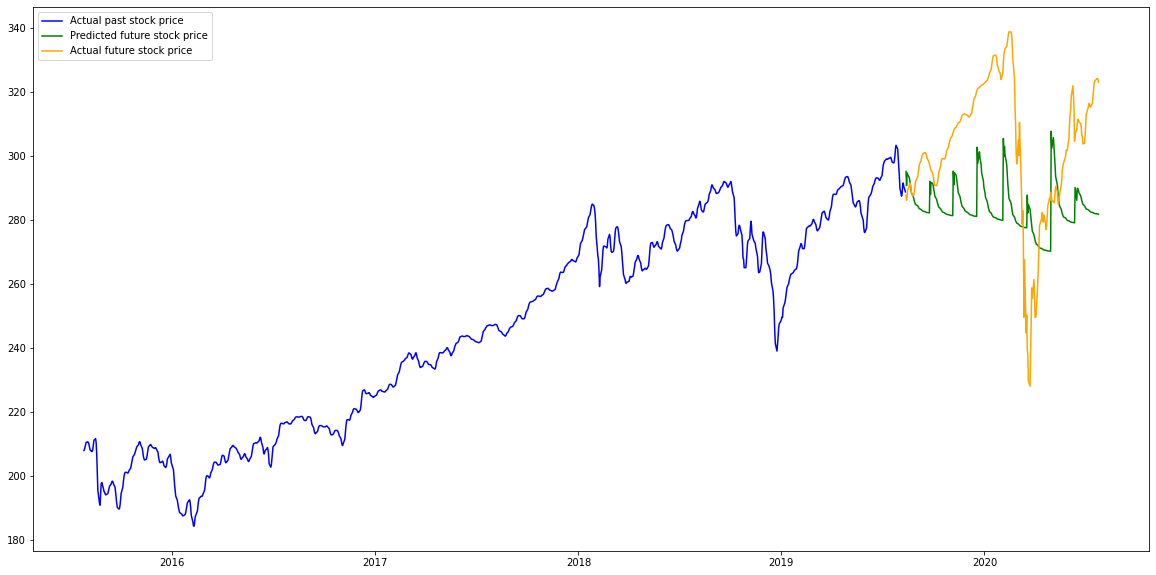

In [255]:
#for plotting
train = new_data[:len(train)]
#train_pred = new_data[T:450]
valid = new_data[len(train):]
#train_pred['Predictions'] = closing_price_train
valid['Predictions'] = closing_price.reshape(-1,1)
plt.plot(train['Close'], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()